# Credit Card Approval Prediction

## Import and read data

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [2]:
df_record = pd.read_csv('credit_record.csv')
df_app = pd.read_csv('application_record.csv')

In [3]:
df_app.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [4]:
df_record.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


## Merging datasets

In [3]:
# a user's account open month is defined as the earliest month that is recorded in the 'MONTHS_BALANCE' column
df_record_copy = df_record.groupby(by='ID', as_index=False)['MONTHS_BALANCE'].min().copy()
df_record_copy.rename(columns={'MONTHS_BALANCE': 'acc_open'}, inplace=True)

In [4]:
# Now merging the acc_open and the application data based on ID, since they are unqiue
df = pd.merge(df_app, df_record_copy, how='left', on='ID')

Status column of the record.csv data: 0: 1-29 days past due 1: 30-59 days past due 2: 60-89 days overdue 3: 90-119 days overdue 4: 120-149 days overdue 5: Overdue or bad debts, write-offs for more than 150 days C: paid off that month X: No loan for the month

In [5]:
# map the new judge column based on user credit, anything over 60 days overdue is mapped as 0, otherwise 1
df_record['judge'] = None
df_record.loc[(df_record['STATUS'] == '2') | (df_record['STATUS'] == '3') | (df_record['STATUS'] == '4') | (df_record['STATUS'] == '5'), 'judge'] = 'Yes'
df_record.head()

,ID,MONTHS_BALANCE,STATUS,judge
0,5001711,0,X,None
1,5001711,-1,0,None
2,5001711,-2,0,None
3,5001711,-3,0,None
4,5001712,0,C,None


In [6]:
new = df_record.groupby(by='ID').count()
new = new[['judge']]
new.loc[new.judge > 0, 'judge'] = 'Pass'
new.loc[new.judge == 0, 'judge'] = 'NG'
df = pd.merge(df, new, how='inner', on='ID')
df.loc[df.judge == 'NG', 'judge'] = 0
df.loc[df.judge == 'Pass', 'judge'] = 1

In [9]:
df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,acc_open,judge
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-15.0,0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-14.0,0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,-29.0,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-4.0,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-26.0,0


In [7]:
df = df.mask(df == 'NULL').dropna()

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25134 entries, 2 to 36456
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   25134 non-null  int64  
 1   CODE_GENDER          25134 non-null  object 
 2   FLAG_OWN_CAR         25134 non-null  object 
 3   FLAG_OWN_REALTY      25134 non-null  object 
 4   CNT_CHILDREN         25134 non-null  int64  
 5   AMT_INCOME_TOTAL     25134 non-null  float64
 6   NAME_INCOME_TYPE     25134 non-null  object 
 7   NAME_EDUCATION_TYPE  25134 non-null  object 
 8   NAME_FAMILY_STATUS   25134 non-null  object 
 9   NAME_HOUSING_TYPE    25134 non-null  object 
 10  DAYS_BIRTH           25134 non-null  int64  
 11  DAYS_EMPLOYED        25134 non-null  int64  
 12  FLAG_MOBIL           25134 non-null  int64  
 13  FLAG_WORK_PHONE      25134 non-null  int64  
 14  FLAG_PHONE           25134 non-null  int64  
 15  FLAG_EMAIL           25134 non-null 

## Feature Engineering

### Binary Data

* gender
* car
* realty

In [12]:
# checking whether marriage status is a binary type of data
df.NAME_FAMILY_STATUS.unique()

array(['Married', 'Single / not married', 'Civil marriage', 'Separated',
       'Widow'], dtype=object)

In [8]:
# gender
df.loc[df.CODE_GENDER == 'M', 'CODE_GENDER'] = 1
df.loc[df.CODE_GENDER == 'F', 'CODE_GENDER'] = 0
df['CODE_GENDER']

2        1
3        0
4        0
5        0
6        0
        ..
36452    1
36453    0
36454    0
36455    0
36456    1
Name: CODE_GENDER, Length: 25134, dtype: object

In [9]:
# car
df.loc[df.FLAG_OWN_CAR == 'Y', 'FLAG_OWN_CAR'] = 1
df.loc[df.FLAG_OWN_CAR == 'N', 'FLAG_OWN_CAR'] = 0
df['FLAG_OWN_CAR']

2        1
3        0
4        0
5        0
6        0
        ..
36452    1
36453    0
36454    0
36455    0
36456    0
Name: FLAG_OWN_CAR, Length: 25134, dtype: object

In [10]:
# realty
df.loc[df.FLAG_OWN_REALTY == 'Y', 'FLAG_OWN_REALTY'] = 1
df.loc[df.FLAG_OWN_REALTY == 'N', 'FLAG_OWN_REALTY'] = 0
df['FLAG_OWN_REALTY']

2        1
3        1
4        1
5        1
6        1
        ..
36452    1
36453    1
36454    1
36455    1
36456    1
Name: FLAG_OWN_REALTY, Length: 25134, dtype: object

In [16]:
df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,acc_open,judge
2,5008806,1,1,1,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,-29.0,0
3,5008808,0,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-4.0,0
4,5008809,0,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-26.0,0
5,5008810,0,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-26.0,0
6,5008811,0,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-38.0,0


### Categorical Data

* income type
* education type
* family status
* housing type
* occupation type

In [11]:
cat_cols = ['NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_HOUSING_TYPE', 'NAME_FAMILY_STATUS', 'OCCUPATION_TYPE']
for item in cat_cols:
    df[item] = df[item].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25134 entries, 2 to 36456
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   ID                   25134 non-null  int64   
 1   CODE_GENDER          25134 non-null  object  
 2   FLAG_OWN_CAR         25134 non-null  object  
 3   FLAG_OWN_REALTY      25134 non-null  object  
 4   CNT_CHILDREN         25134 non-null  int64   
 5   AMT_INCOME_TOTAL     25134 non-null  float64 
 6   NAME_INCOME_TYPE     25134 non-null  category
 7   NAME_EDUCATION_TYPE  25134 non-null  category
 8   NAME_FAMILY_STATUS   25134 non-null  category
 9   NAME_HOUSING_TYPE    25134 non-null  category
 10  DAYS_BIRTH           25134 non-null  int64   
 11  DAYS_EMPLOYED        25134 non-null  int64   
 12  FLAG_MOBIL           25134 non-null  int64   
 13  FLAG_WORK_PHONE      25134 non-null  int64   
 14  FLAG_PHONE           25134 non-null  int64   
 15  FLAG_EMAIL         

In [12]:
# income type
it = {'Working': 1, 'Commercial associate': 2, 'State servant': 3, 'Student': 4, 'Pensioner': 5}
df.NAME_INCOME_TYPE = df['NAME_INCOME_TYPE'].apply(lambda x: it[x])

In [13]:
# education type
df.NAME_EDUCATION_TYPE.unique()
et = {'Academic degree': 1, 'Higher education': 2, 'Incomplete higher': 3, 'Lower secondary': 4, 'Secondary / secondary special': 5}
df['NAME_EDUCATION_TYPE'] = df['NAME_EDUCATION_TYPE'].apply(lambda x: et[x])

In [14]:
# family status
df.NAME_FAMILY_STATUS.unique()
fs = {'Civil marriage': 1, 'Married': 2, 'Separated': 3, 'Single / not married': 4, 'Widow': 5}
df['NAME_FAMILY_STATUS'] = df['NAME_FAMILY_STATUS'].apply(lambda x: fs[x])

In [15]:
# housing type
df.NAME_HOUSING_TYPE.unique()

['House / apartment', 'Rented apartment', 'Municipal apartment', 'With parents', 'Co-op apartment', 'Office apartment']
Categories (6, object): ['Co-op apartment', 'House / apartment', 'Municipal apartment', 'Office apartment', 'Rented apartment', 'With parents']

In [16]:
ht = {'House / apartment': 1, 'Rented apartment': 2, 'Municipal apartment': 3, 'With parents': 4, 'Co-op apartment': 5, 'Office apartment': 6}
df['NAME_HOUSING_TYPE'] = df['NAME_HOUSING_TYPE'].apply(lambda x: ht[x])

In [17]:
# occupation type
df.OCCUPATION_TYPE = df.OCCUPATION_TYPE.astype(str)
# grouping different occupations to category: working class, office class and IT class
df.loc[(df.OCCUPATION_TYPE == 'Security staff') | (df.OCCUPATION_TYPE == 'Laborers') | (df.OCCUPATION_TYPE == 'Drivers') | (df.OCCUPATION_TYPE == 'Cleaning staff') | (df.OCCUPATION_TYPE == 'Cooking staff') | (df.OCCUPATION_TYPE == 'Low-skill Laborers') | (df.OCCUPATION_TYPE == 'Waiters/barmen staff'), 'OCCUPATION_TYPE'] = 0
df.loc[(df.OCCUPATION_TYPE == 'Sales staff') | (df.OCCUPATION_TYPE == 'Accountants') | (df.OCCUPATION_TYPE == 'Managers') | (df.OCCUPATION_TYPE == 'Core staff') | (df.OCCUPATION_TYPE == 'Private service staff') | (df.OCCUPATION_TYPE == 'Medicine staff') | (df.OCCUPATION_TYPE == 'Secretaries') | (df.OCCUPATION_TYPE == 'HR staff') | (df.OCCUPATION_TYPE == 'Realty agents'), 'OCCUPATION_TYPE'] = 1
df.loc[(df.OCCUPATION_TYPE == 'High skill tech staff') | (df.OCCUPATION_TYPE == 'IT staff'), 'OCCUPATION_TYPE'] = 2
df.OCCUPATION_TYPE

2        0
3        1
4        1
5        1
6        1
        ..
36452    1
36453    1
36454    1
36455    1
36456    0
Name: OCCUPATION_TYPE, Length: 25134, dtype: object

In [38]:
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25134 entries, 2 to 36456
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   ID                   25134 non-null  int64   
 1   CODE_GENDER          25134 non-null  object  
 2   FLAG_OWN_CAR         25134 non-null  object  
 3   FLAG_OWN_REALTY      25134 non-null  object  
 4   CNT_CHILDREN         25134 non-null  int64   
 5   AMT_INCOME_TOTAL     25134 non-null  float64 
 6   NAME_INCOME_TYPE     25134 non-null  category
 7   NAME_EDUCATION_TYPE  25134 non-null  category
 8   NAME_FAMILY_STATUS   25134 non-null  category
 9   NAME_HOUSING_TYPE    25134 non-null  category
 10  DAYS_BIRTH           25134 non-null  int64   
 11  DAYS_EMPLOYED        25134 non-null  int64   
 12  FLAG_MOBIL           25134 non-null  int64   
 13  FLAG_WORK_PHONE      25134 non-null  int64   
 14  FLAG_PHONE           25134 non-null  int64   
 15  FLAG_EMAIL         

## Feature and response combination

### Defining data X & Y

In [25]:
x = df[['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS']]
y = df.judge.astype(int)
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0)
score = []

### KNN

7 0.9837875472448777


<AxesSubplot: >

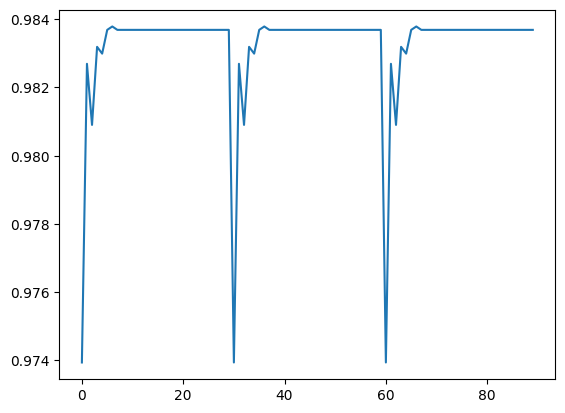

In [42]:
# getting best neighboring number for KNN: around 15
for i in range(1, 31):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_train, y_train)
    y_pred_knn = knn.predict(x_test)
    score.append(metrics.accuracy_score(y_pred, y_test))
best_knn = np.argmax(score) + 1
KNN_score = np.max(score)
algo_compare = [KNN_score]
sns.lineplot(score)

In [56]:
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(x_train, y_train)
y_pred_knn = knn.predict(x_test)
print(f'Accuracy score of KNN is: {round(metrics.accuracy_score(y_pred_knn, y_test), 4)*100}%')

Accuracy score of KNN is: 98.38%


### Random Forest Classifier

In [57]:
rfc = RandomForestClassifier(n_estimators=250, max_depth=12, min_samples_leaf=16)
rfc.fit(x_train, y_train)
y_pred_rfc = rfc.predict(x_test)
print(f'Accuracy score of Random Forest Classifier is: {round(metrics.accuracy_score(y_pred_rfc, y_test), 4)*100}%')

Accuracy score of Random Forest Classifier is: 98.38%


### Logistic Regression

In [28]:
logreg = LogisticRegression(solver='liblinear')
logreg.fit(x_train, y_train)
y_pred_logreg = logreg.predict(x_test)
logreg.predict_proba(x_test)[0:10, 1]
#y_pred__logreg_prob = logreg.predict_proba(x_test)[:, 1]
#print(metrics.confusion_matrix(y_pred_logreg, y_test))
#print(f'Accuracy score of Logistic Regression is: {round(metrics.accuracy_score(y_pred_logreg, y_test), 4)*100}%')

array([0.00025327, 0.03514976, 0.01193312, 0.03515042, 0.00025327,
       0.03515066, 0.00398768, 0.01193287, 0.02054442, 0.05950876])

In [62]:
print(1/61)

0.01639344262295082


In [22]:
x_test

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
17964,0,1,1,0,337500.0,1,5,4,1,1,0,0,0,1,1.0
6133,0,0,1,1,135000.0,1,5,2,1,1,0,1,0,0,3.0
4219,0,1,0,0,180000.0,1,2,2,4,1,1,1,0,1,2.0
3068,1,1,1,1,135000.0,2,2,2,1,1,0,0,0,1,3.0
12113,0,0,0,2,337500.0,1,5,2,1,1,0,0,0,1,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21086,1,1,1,0,256500.0,1,2,4,1,1,0,0,1,2,1.0
5111,0,0,1,1,225000.0,2,5,2,1,1,0,0,0,1,3.0
18330,0,1,1,1,279000.0,1,2,1,1,1,1,1,0,1,3.0
10119,1,0,1,2,360000.0,3,2,2,1,1,0,1,0,1,4.0


In [23]:
x_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6284 entries, 17964 to 27335
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   CODE_GENDER          6284 non-null   object  
 1   FLAG_OWN_CAR         6284 non-null   object  
 2   FLAG_OWN_REALTY      6284 non-null   object  
 3   CNT_CHILDREN         6284 non-null   int64   
 4   AMT_INCOME_TOTAL     6284 non-null   float64 
 5   NAME_INCOME_TYPE     6284 non-null   category
 6   NAME_EDUCATION_TYPE  6284 non-null   category
 7   NAME_FAMILY_STATUS   6284 non-null   category
 8   NAME_HOUSING_TYPE    6284 non-null   category
 9   FLAG_MOBIL           6284 non-null   int64   
 10  FLAG_WORK_PHONE      6284 non-null   int64   
 11  FLAG_PHONE           6284 non-null   int64   
 12  FLAG_EMAIL           6284 non-null   int64   
 13  OCCUPATION_TYPE      6284 non-null   object  
 14  CNT_FAM_MEMBERS      6284 non-null   float64 
dtypes: category(4), 

In [24]:
col_name = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'OCCUPATION_TYPE']
for j in col_name:
    df[j] = df[j].astype(int)

In [26]:
x_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6284 entries, 17964 to 27335
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   CODE_GENDER          6284 non-null   int64   
 1   FLAG_OWN_CAR         6284 non-null   int64   
 2   FLAG_OWN_REALTY      6284 non-null   int64   
 3   CNT_CHILDREN         6284 non-null   int64   
 4   AMT_INCOME_TOTAL     6284 non-null   float64 
 5   NAME_INCOME_TYPE     6284 non-null   category
 6   NAME_EDUCATION_TYPE  6284 non-null   category
 7   NAME_FAMILY_STATUS   6284 non-null   category
 8   NAME_HOUSING_TYPE    6284 non-null   category
 9   FLAG_MOBIL           6284 non-null   int64   
 10  FLAG_WORK_PHONE      6284 non-null   int64   
 11  FLAG_PHONE           6284 non-null   int64   
 12  FLAG_EMAIL           6284 non-null   int64   
 13  OCCUPATION_TYPE      6284 non-null   int64   
 14  CNT_FAM_MEMBERS      6284 non-null   float64 
dtypes: category(4), 